In [53]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from copy import deepcopy

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import psf

# Generate images with various PSFs

In [54]:
lens = SampleStrongLens()

num_pix = 45
side = 4.95
band = 'F184'

## Grab default substructure

In [55]:
# add CDM subhalos; NB same subhalo population for all
# lens.add_subhalos(util.unpickle(os.path.join(pickle_dir, 'cdm_subhalos_for_sample')))

## No PSF

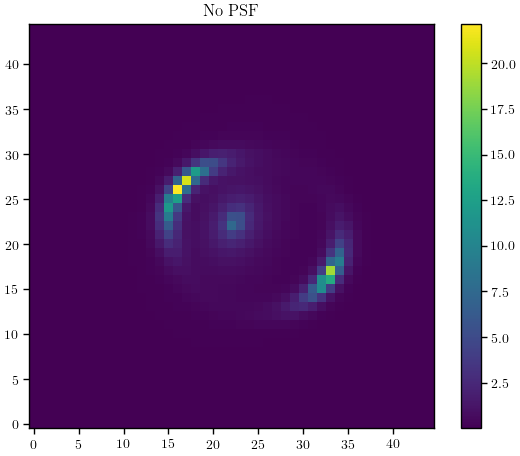

(45, 45)


In [56]:
no_psf_lens = deepcopy(lens)

kwargs_psf_none = {'psf_type': 'NONE'}

no_psf = no_psf_lens.get_array(band=band, num_pix=num_pix, kwargs_psf=kwargs_psf_none, side=side)

plot.plot(title='No PSF',
          array=no_psf,
          colorbar=True)

np.save(os.path.join(array_dir, 'sample_skypy_lens', 'no_psf.npy'), no_psf)

print(no_psf.shape)

## Gaussian PSF

I'm getting the PSF FWHM values from [here](https://roman.gsfc.nasa.gov/science/WFI_technical.html). From that webpage: "Note: PSF FWHM in arcseconds simulated at the center of the center pixel of a detector near the center of the WFI FOV using an input spectrum for a K0V type star."

In [57]:
psf_fwhm = {
    'F062': 0.058,
    'F087': 0.073,
    'F106': 0.087,
    'F129': 0.105,
    'F158': 0.127,
    'F184': 0.151,
    'F213': 0.175,
    'F146': 0.105
}

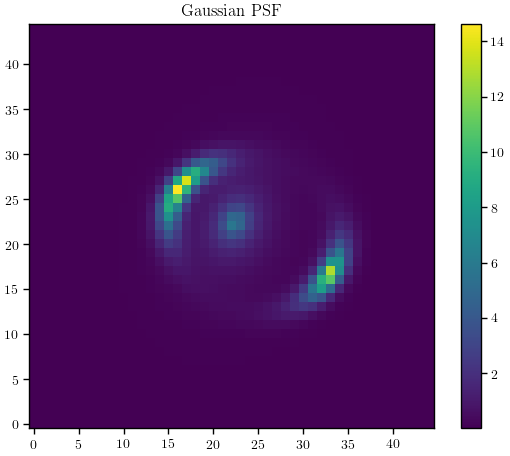

(45, 45)


In [58]:
gaussian_psf_lens = deepcopy(lens)

kwargs_psf_gaussian = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm.get(band)}

gaussian_psf = gaussian_psf_lens.get_array(band=band, num_pix=num_pix, kwargs_psf=kwargs_psf_gaussian, side=side)

plot.plot(title='Gaussian PSF',
          array=gaussian_psf,
          colorbar=True)

np.save(os.path.join(array_dir, 'sample_skypy_lens', 'gaussian_psf.npy'), gaussian_psf)

print(gaussian_psf.shape)

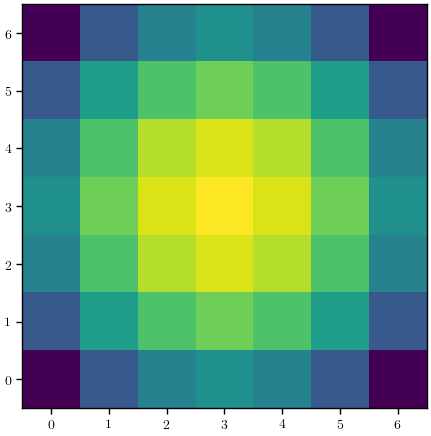

In [66]:
from lenstronomy.Data.psf import PSF

kwargs_psf_gaussian['pixel_size'] = 0.11
gaussian = PSF(**kwargs_psf_gaussian)

plt.imshow(np.log10(gaussian.kernel_point_source))
plt.show()

## WebbPSF

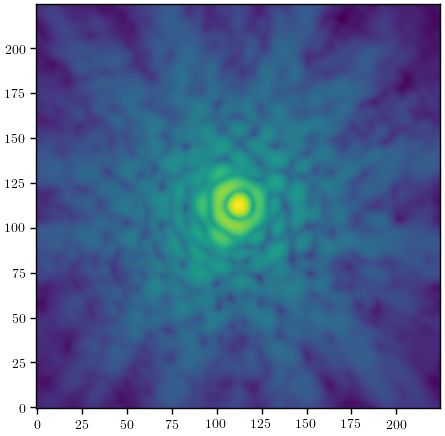

In [62]:
detector = 1
detector_position = (2048, 2048)
kernel = psf.get_psf_kernel(band, detector, detector_position, oversample=5)

plt.imshow(np.log10(kernel))
plt.show()

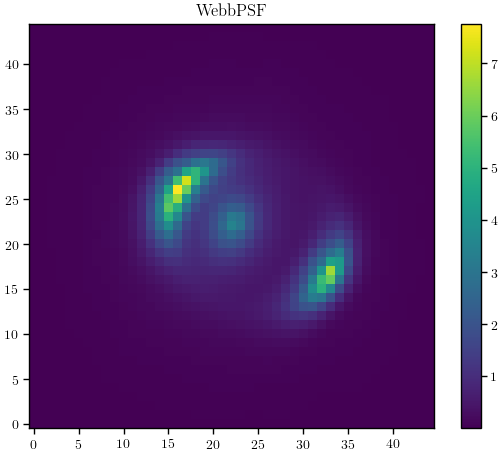

(45, 45)


In [63]:
webbpsf_lens = deepcopy(lens)

kwargs_webbpsf = {
    'psf_type': 'PIXEL',
    'kernel_point_source': kernel,
    'point_source_supersampling_factor': 5
    }

webbpsf_psf = webbpsf_lens.get_array(band=band, num_pix=num_pix, kwargs_psf=kwargs_webbpsf, side=side)

plot.plot(title='WebbPSF',
          array=webbpsf_psf,
          colorbar=True)

np.save(os.path.join(array_dir, 'sample_skypy_lens', 'webbpsf.npy'), webbpsf_psf)

print(webbpsf_psf.shape)

# Plot

In [9]:
no_psf = np.load(os.path.join(array_dir, 'sample_skypy_lens', 'no_psf.npy'))
gaussian_psf = np.load(os.path.join(array_dir, 'sample_skypy_lens', 'gaussian_psf.npy'))
webbpsf = np.load(os.path.join(array_dir, 'sample_skypy_lens', 'webbpsf.npy'))

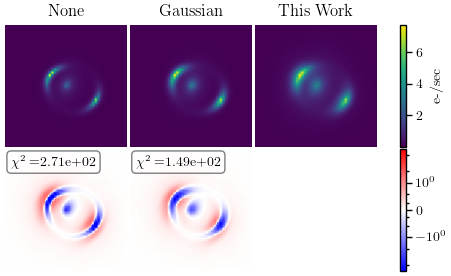

In [51]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(6, 3.2), gridspec_kw={'hspace': 0.02, 'wspace': 0.02})  # 

array_list = [no_psf, gaussian_psf, webbpsf]
title_list = ['None', 'Gaussian', 'This Work']

for i, array in enumerate(array_list):
    axis_1 = ax[0][i].imshow((array), cmap='viridis')
    ax[0][i].set_title(title_list[i])
    ax[0][i].set_axis_off()

cbar = fig.colorbar(axis_1, ax=ax[0])
cbar.set_label('e-/sec', rotation=90)

array_list = [webbpsf - no_psf, webbpsf - gaussian_psf]  # , gaussian_psf - no_psf
title_list = ['WebbPSF - No PSF', 'WebbPSF - Gaussian PSF']  # , 'Gaussian PSF - No PSF'

# compute mean chi square
chi_square_list = []
chi_square_list.append(stats.chi_square(no_psf, webbpsf))
chi_square_list.append(stats.chi_square(gaussian_psf, webbpsf))
# chi_square_list.append(stats.chi_square(gaussian_psf, no_psf))
chi_square_list = ['$\chi^2 = $' + '{:.2e}'.format(i) for i in chi_square_list]

norm = plot_util.get_norm(array_list, linear_width=0.5)
props = dict(boxstyle='round', facecolor='w', alpha=0.5)

ax[1][0].imshow(webbpsf - no_psf, cmap='bwr', norm=norm)
axis_2 = ax[1][1].imshow(webbpsf - gaussian_psf, cmap='bwr', norm=norm)
ax[1][0].text(0.05, 0.95, chi_square_list[0], transform=ax[1][0].transAxes,
            verticalalignment='top', bbox=props)
ax[1][1].text(0.05, 0.95, chi_square_list[1], transform=ax[1][1].transAxes,
            verticalalignment='top', bbox=props)

for each in ax[1]:
    each.set_axis_off()

cbar_residuals = fig.colorbar(axis_2, ax=ax[1], ticks=[-1, 0, 1])
# cbar_residuals.set_label('e-/sec', rotation=90)

plt.savefig(os.path.join(figure_dir, 'psf_compare.png'))
plt.show()